<a href="https://colab.research.google.com/github/87tana/Image-Semantic-Segmentation/blob/main/Tumor_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set up environment

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [2]:
cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


In [3]:
# Path to dataset
root_dir = '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/Tumor_Segmentation'


In [4]:
import os
import cv2
import json
import random
from PIL import Image
import pandas as pd
import numpy as np
import skimage.draw

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import skimage  # import scikit_image
#import tifffile  # for reading and writing TIFF
#import shutil #Higher-level interface for file operations, including file copying, removal, and archiving

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
# from torchvision.datasets import YourDatasetClass


# 2. Data Prepration

## 2.1. Creating DataFrame

To handle the dataset, we initialize a dataframe and extract crucial details from it. This involves parsing annotations stored in JSON files for each subset of the dataset (train, valid, test). For each image, the program locates the corresponding annotation, retrieves pertinent data, and organizes it into lists. In case an annotation is absent for an image, a warning message is printed. Finally, a dictionary named 'dic' is constructed, consolidating all the extracted information.

In [16]:
"""
Read JSON files and extract image and annotation information.
Store them in lists and then create a dictionary.
Finally create a pandas dataframe using the dctionary.
"""

file_name = []
width = []
height = []
category_id = []
segmentation = []
subset = []

for s in ['train', 'valid', 'test']:
  with open(os.path.join(root_dir,s,'_annotations.coco.json'),'r') as file:
    data = json.load(file)
    for id in range(len(data['images'])):
      # Flag to check the annotation availability
      ann_available=False
      # Look for the corresponding annotation
      for j in range(id,len(data['images'])):
        if data['annotations'][j]['image_id'] == data['images'][id]['id']:
          category_id.append(data['annotations'][j]['category_id'])
          segmentation.append(data['annotations'][j]['segmentation'])
          ann_available=True
          break

      if ann_available:
        file_name.append(data['images'][id]['file_name'])
        width.append(data['images'][id]['width'])
        height.append(data['images'][id]['height'])
        subset.append(s)
      else:
        print(f'Annotation is missing for image {id} in {s}')



dic = {'file_name': file_name, 'width': width , 'height': height,\
        'category_id': category_id, 'segmentation': segmentation, 'subset': subset}

df = pd.DataFrame.from_dict(dic)
df.tail()

Annotation is missing for image 1380 in train


,file_name,width,height,category_id,segmentation,subset
2140,2456_jpg.rf.fbc4e1bf546033f504b0adbf5959bb50.jpg,640,640,1,"[[407.5, 251.25, 180, 251.25, 180, 452.5, 407....",test
2141,1361_jpg.rf.d77d067dfc6aa94df76a98a34bea8ed5.jpg,640,640,2,"[[297.5, 275, 202.5, 275, 202.5, 390, 297.5, 3...",test
2142,1058_jpg.rf.f6d6dcde9564c091b30eb6873641ba36.jpg,640,640,2,"[[423.75, 276.25, 352.5, 276.25, 352.5, 352.5,...",test
2143,2817_jpg.rf.eeb513c4ab3414fdda2bbba660318b57.jpg,640,640,1,"[[281.25, 386.25, 157.5, 386.25, 157.5, 530, 2...",test
2144,2279_jpg.rf.fad5e232a1764258d0c26e17e0562019.jpg,640,640,1,"[[353.75, 373.75, 227.5, 373.75, 227.5, 481.25...",test


In [17]:
def create_mask(image_info):

  """ - The function aims to create a binary mask based on the segmentation information provided.
        It iterates over each segmentation entry in the image_info['segmentation'] list.
        it extracts the polygon coordinates from the segmentation list.
        pixels inside the segmented regions are set to 1 and pixels outside are set to 0.
  """
  mask_np = np.zeros((image_info['height'],image_info['width']),dtype=np.uint8)

  for seg_idx ,seg in enumerate(image_info['segmentation']):
      rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
      mask_np[rr,cc]=1

  return mask_np

## 2.2 Data Images Glimpse, Class 1 and Class 2 are both Tumor

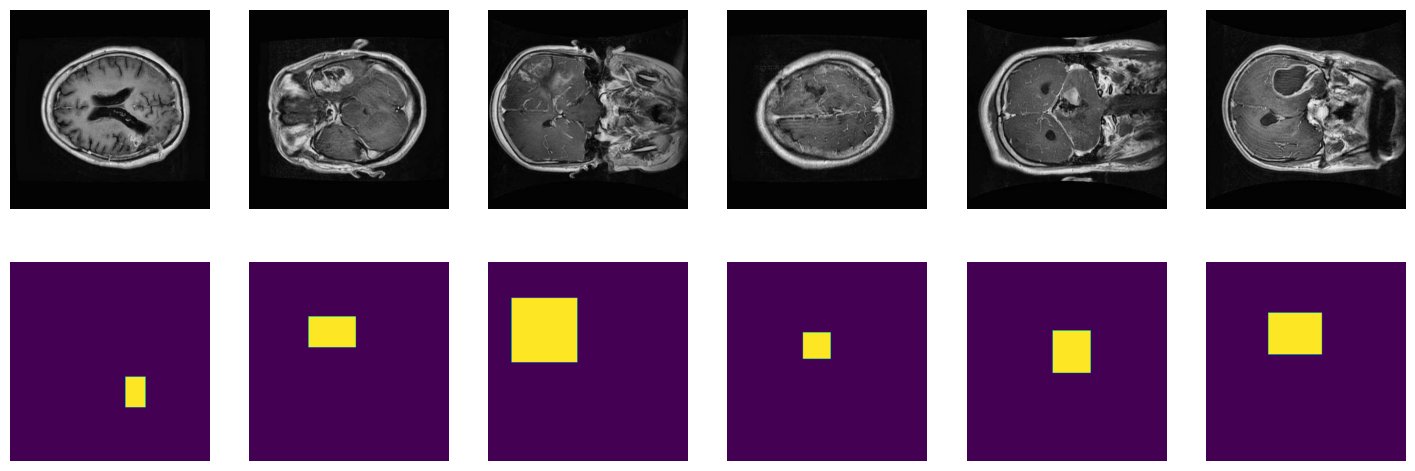

In [22]:
samp = df[df['category_id']==1].sample(6).reset_index(drop=True)

fig, axes = plt.subplots (2,6,figsize=(18,6))

for i in range(len(samp)): # index and image path
    img = mpimg.imread(os.path.join(root_dir,samp.loc[i]['subset'],samp.loc[i]['file_name']))
    axes[0,i].imshow(img)
    axes[0,i].axis('off') # Turn off axis labels
    mask = create_mask(samp.loc[i])
    axes[1,i].imshow(mask)
    axes[1,i].axis('off') # Turn off axis labels

plt.show()


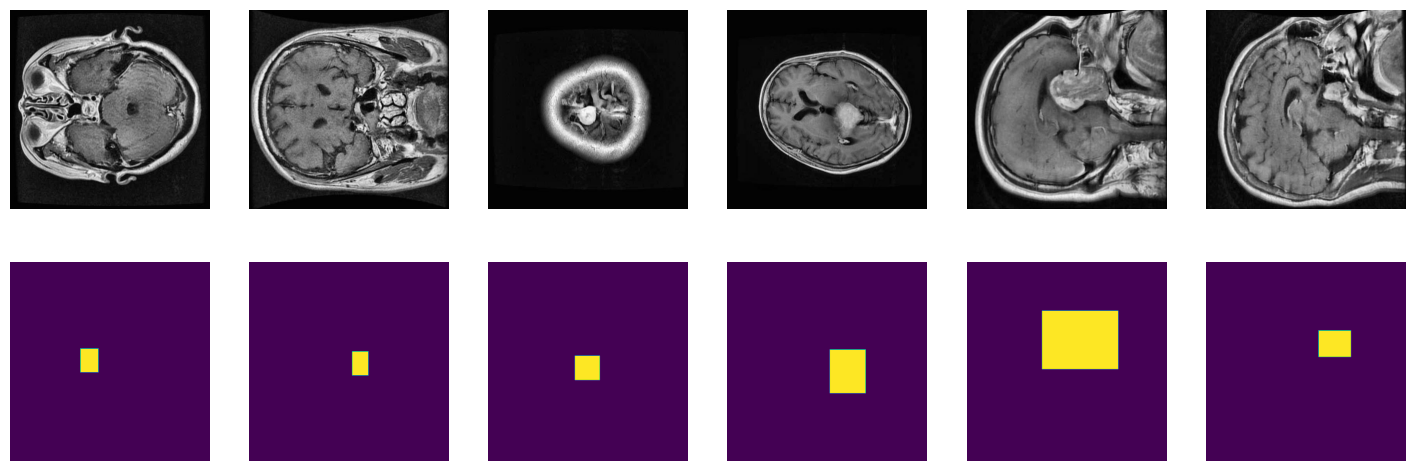

In [24]:
samp = df[df['category_id']==2].sample(6).reset_index(drop=True)

fig, axes = plt.subplots (2,6,figsize=(18,6))

for i in range(len(samp)): # index and image path
    img = mpimg.imread(os.path.join(root_dir,samp.loc[i]['subset'],samp.loc[i]['file_name']))
    axes[0,i].imshow(img)
    axes[0,i].axis('off') # Turn off axis labels
    mask = create_mask(samp.loc[i])
    axes[1,i].imshow(mask)
    axes[1,i].axis('off') # Turn off axis labels

plt.show()

In [34]:
"""
Dataset class. Read images and create an iterator used in the dataloader.
"""
class SegmentationDataset():
    def __init__(self, root_dir, df, subset, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.data_ = []  #Loading image-mask pairs from the dataset into memory and storing them in a list called self.data_.

        for i in tqdm(range(10), desc=subset):#tqdm(range(len(df))):
          img = cv2.imread(os.path.join(root_dir,subset,df.loc[i]['file_name']))
          mask = create_mask(df.loc[i]) # Create mask
          self.data_.append({'image': img, 'mask': mask}) # add image and its mask to a list.

    def __len__(self):
        return len(self.data_)

    def __getitem__(self, idx):

        image = self.data_[idx]['image']
        mask = self.data_[idx]['mask']

        if self.transform is not None:
          image = self.transform['image'](image)
          mask = self.transform['mask'](mask)

        return image, mask

In [35]:
"""
Create train and validation dataloaders.
"""

# Define the transformations for images and masks.
transform_img= transforms.Compose([transforms.ToTensor()])
transform_mask = transforms.Compose([transforms.ToTensor(),transforms.Resize((80, 80))])
transform = {'image': transform_img, 'mask': transform_mask}


# Train dataloader
train_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='train'].reset_index(drop=True), subset='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

# Validation dataloader.
valid_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='valid'].reset_index(drop=True), subset='valid', transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=False)

valid: 100%|██████████| 10/10 [00:00<00:00, 51.39it/s]


In [36]:
# Define sample CNN model for segmentation
class SegmentationCNN(nn.Module):
    def __init__(self):
        super(SegmentationCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 1, 3, padding=1)  # Output is a single channel for binary segmentation
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.conv4(x)
        return x

In [37]:
# Initialize the model, loss function, and optimizer
model = SegmentationCNN()
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [38]:
# Set the max number of epochs, and validation step.
num_epochs = 10
valid_step = 2
# Set the device to GPU if availabel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the device.
model.to(device)

SegmentationCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [39]:
# Training loop

sample_val_result = []
train_loss = []
valid_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for step, (images, masks) in enumerate(train_loader):

        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss.append([epoch, epoch_loss])
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation
    if epoch % valid_step == 0 or epoch == num_epochs-1:
      model.eval()
      valid_loss_sum = 0
      with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            valid_loss_sum += criterion(outputs, masks).item() * images.size(0)

            sample_val_result.append({'image':images[0], 'mask':masks[0], 'pred':outputs[0]})

        avg_valid_loss = valid_loss_sum / len(valid_loader.dataset)
        valid_loss.append([epoch, avg_valid_loss])
        print(f"Average Valid Loss: {avg_valid_loss:.4f}")



Epoch [1/10], Loss: 0.5663
Average Valid Loss: 0.0723
Epoch [2/10], Loss: 0.0340
Epoch [3/10], Loss: 0.0103
Average Valid Loss: 0.0140
Epoch [4/10], Loss: 0.0218
Epoch [5/10], Loss: 0.0330
Average Valid Loss: 0.0281
Epoch [6/10], Loss: 0.0397
Epoch [7/10], Loss: 0.0429
Average Valid Loss: 0.0314
Epoch [8/10], Loss: 0.0423
Epoch [9/10], Loss: 0.0383
Average Valid Loss: 0.0249
Epoch [10/10], Loss: 0.0324
Average Valid Loss: 0.0199


In [40]:
np.vstack(train_loss)[:,1]

array([0.56633866, 0.03402013, 0.01027703, 0.02182105, 0.03299918,
       0.03971589, 0.04289972, 0.04230536, 0.03826304, 0.0323909 ])

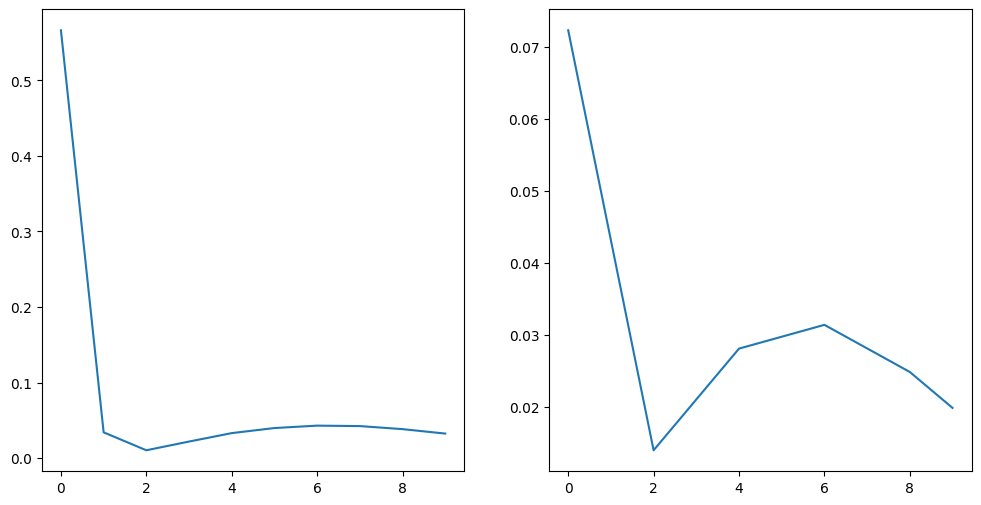

In [41]:
"""
Plot train and validation curves
"""

fig, axes = plt.subplots (1,2,figsize=(12,6))

axes[0].plot(np.vstack(train_loss)[:,0],np.vstack(train_loss)[:,1])
axes[1].plot(np.vstack(valid_loss)[:,0],np.vstack(valid_loss)[:,1])

(-0.5, 79.5, 79.5, -0.5)

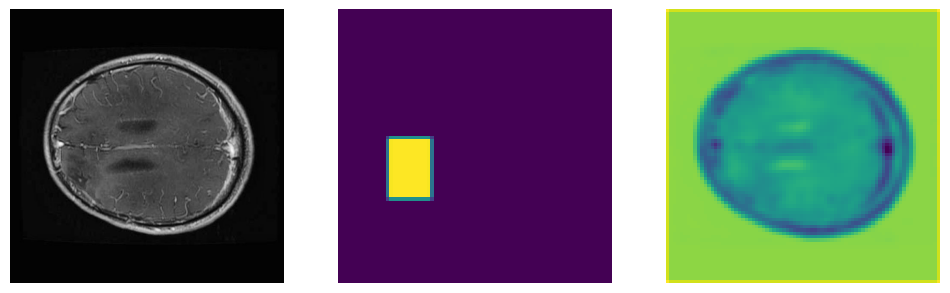

In [43]:
"""
Visualize sample validation result.
"""
idx = 10

fig, axes = plt.subplots (1,3,figsize=(12,6))

axes[0].imshow(sample_val_result[idx]['image'].permute(1, 2, 0))
axes[1].imshow(sample_val_result[idx]['mask'].permute(1, 2, 0))
axes[2].imshow(sample_val_result[idx]['pred'].permute(1, 2, 0))

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')